<a href="https://colab.research.google.com/github/OpenCV13/dm/blob/main/module_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Anomaly Detection

The following tutorial contains Python examples for detecting anomalies (outliers) from data. You should refer to Chapters 9 of the "Introduction to Data Mining" book to understand some of the concepts introduced in this tutorial. The notebook can be downloaded from http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial9/tutorial9.ipynb.

Anomaly detection is the task of identifying instances whose characteristics differ significantly from the rest of the data. In this tutorial, we will provide examples of applying different anomaly detection techniques using Python and its library packages.

Read the step-by-step instructions below carefully. To execute the code, click on the corresponding cell and press the SHIFT-ENTER keys simultaneously.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## 9.1 Using Parametric Models

This approach assumes that the majority of the data instances are governed by some well-known probability distribution, e.g., Binomial or Gaussian distribution. Anomalies can then detected by seeking for observations that do not fit the overall distribution of the data.

In this example, our goal is to detect anomalous changes in the daily closing prices of various stocks. The input data *stocks.csv* contains the historical closing prices of stocks for 3 large corporations (Microsoft, Ford Motor Company, and Bank of America).

In [3]:
import pandas as pd

stocks = pd.read_csv('stocks.csv', header='infer' )
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'],axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}}
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on its previous day, $t-1$.

In [4]:
import numpy as np

N,d = stocks.shape
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                    columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


We can plot the distribution of the percentage daily changes in stock price.

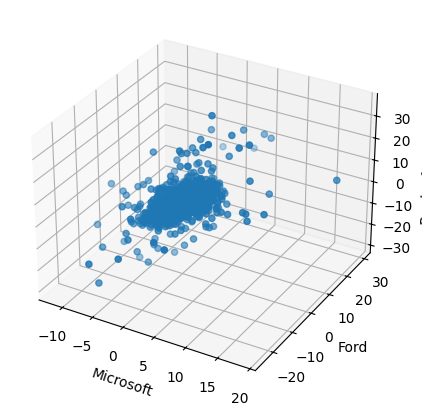

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

#fig = plt.figure(figsize=(8,5)).gca(projection='3d')
fig = plt.figure(figsize=(8,5)).add_subplot(projection='3d')
fig.scatter(delta.MSFT,delta.F,delta.BAC)
fig.set_xlabel('Microsoft')
fig.set_ylabel('Ford')
fig.set_zlabel('Bank of America')
plt.show()

Assuming the data follows a multivariate Gaussian distribution, we can compute the mean and covariance matrix of the 3-dimensional data as follows

In [6]:
meanValue = delta.mean()
covValue = delta.cov()
print(meanValue)
print(covValue)

MSFT    0.045003
F       0.061374
BAC     0.033351
dtype: float64
          MSFT         F        BAC
MSFT  3.191674  2.136351   2.788870
F     2.136351  8.524944   4.997405
BAC   2.788870  4.997405  13.770761


To determine the anomalous trading days, we can compute the Mahalanobis distance between the percentage of price change on each day against the mean percentage of price change.
\begin{equation}
\textrm{Mahalanobis}(x) = (x - \bar{x}) \Sigma^{-1}(x - \bar{x})^T
\end{equation}
where $x$ is assumed to be a row vector.

See Equation 9.4 in Section 9.3.1 for more information about using Mahalanobis distance for detecting anomalies in multivariate Gaussian distribution.

/tmp/ipykernel_7179/3095918217.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X[:,i] = X[:,i] - meanValue[i]


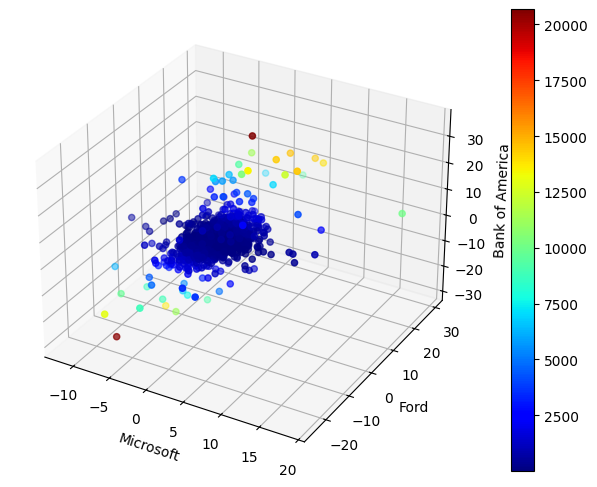

In [7]:
from numpy.linalg import inv

X = delta.values
S = covValue.values
for i in range(3):
    X[:,i] = X[:,i] - meanValue[i]

def mahalanobis(row):
    return np.matmul(row,S).dot(row)

anomaly_score = np.apply_along_axis( mahalanobis, axis=1, arr=X)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=anomaly_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The top-2 anomalies are shown as a brown point in the figure above. The highest anomaly corresponds to the day in which the prices for all 3 stocks increase significantly whereas the second highest anomaly corresponds  to the day in which all 3 stocks suffer a large percentage drop in their closing prices. We can examine the dates associated with the top-2 highest anomaly scores as follows.

In [8]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(2,'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
4/9/2009,2.456295,7.280398,35.235771,20691.465032
10/7/2008,-6.789282,-20.928583,-26.259300,20471.095209


Note that the sharp drop in the stock prices on October 7, 2008 coincide with the beginning of the global financial crisis (https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008) while the increase in the stock prices on April 9, 2009.

Text(0, 0.5, 'Percent Change')

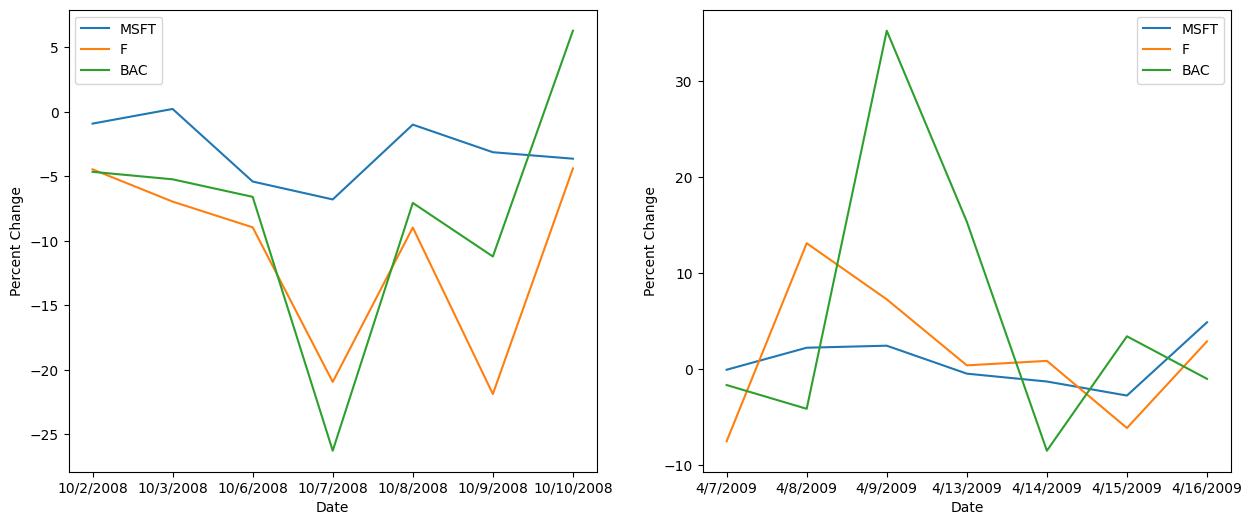

In [9]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ts = delta[440:447]
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts = delta[568:575]
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change')

## 9.2 Using Distance-based Approach

This is a model-free anomaly detection approach as it does not require constructing an explicit model of the normal class to determine the anomaly score of data instances. The example code shown below employs the k-nearest neighbor approach to calculate anomaly score. Specifically, a normal instance is expected to have a small distance to its k-th nearest neighbor whereas an anomaly is likely to have a large distance to its k-th nearest neighbor. In the example below, we apply the distance-based approach with k=4 to identify the anomalous trading days from the stock market data described in the previous section.

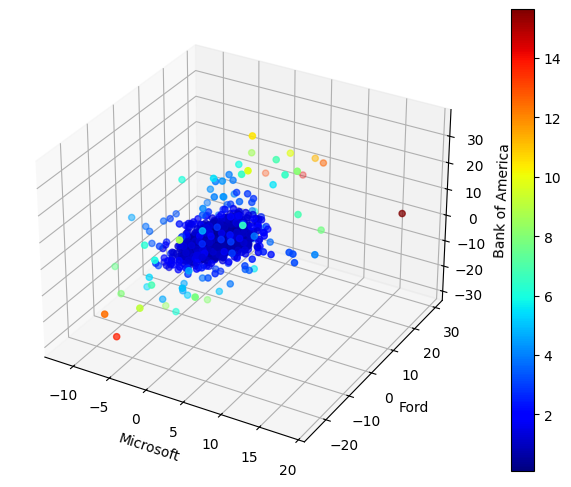

In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(delta.values)
distances, indices = nbrs.kneighbors(delta.values)

anomaly_score = distances[:,knn-1]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=anomaly_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The results are slightly different than the one shown in Section 9.1 since we have used Euclidean distance (instead of Mahalanobis distance) to detect the anomalies. We can examine the dates associated with the top-5 highest anomaly scores as follows.

In [11]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(5,'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
10/13/2008,18.559648,20.039128,9.166457,15.642827
11/26/2008,2.456248,29.456698,4.223406,14.212749
10/7/2008,-6.789282,-20.928583,-26.259300,13.751302
11/28/2008,-1.362724,25.054905,5.280972,13.139586
9/30/2008,6.672314,24.638866,15.669129,12.599739


Text(0, 0.5, 'Percent Change')

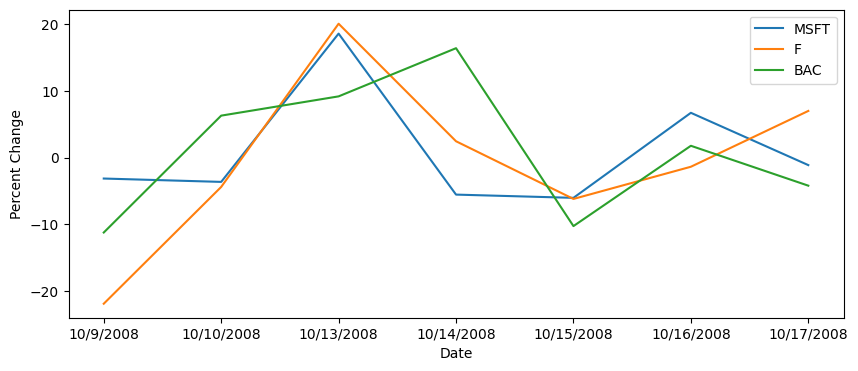

In [12]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ts = delta[445:452]
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')

## 9.3 Summary

This tutorial illustrates examples applying an anomaly detection approach to a multivariate time series data. We consider two approaches, one based on a parametric statistical approach using multivariate Gaussian while the other is a nonparametric distance-based approach using k-nearest neighbor.

## Homework 4 ##

Take the Home_Market_vlaue.csv, and conduct the following analyses.


### 1. Exploratory data analysis on anomaly detection (10 points) ###
Histogram, scatter plot, or Box and Whisker Plot are good starting points. Summarize your findings with markdown cells.

In [13]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance
from numpy.linalg import inv

In [14]:
home = pd.read_csv("Home_Market_Value.csv")
home.head()

,House Age,Square Feet,Market Value
0,33,"1,812","$90,000.00"
1,32,"1,914","$104,400.00"
2,32,"1,842","$93,300.00"
3,33,"1,812","$91,000.00"
4,32,"1,836","$101,900.00"


In [15]:
home_pp = home.replace('[,]?[$]?','', regex=True).astype('float').astype('int')
home_pp


,House Age,Square Feet,Market Value
0,33,1812,90000
1,32,1914,104400
2,32,1842,93300
3,33,1812,91000
4,32,1836,101900
5,33,2028,108500
6,32,1732,87600
7,33,1850,96000
8,32,1791,89200
9,33,1666,88400


In [16]:
home_pp.describe()

,House Age,Square Feet,Market Value
count,42.000000,42.000000,42.000000
mean,29.833333,1695.261905,92069.047619
std,2.428657,220.256730,10553.082733
min,27.000000,1468.000000,76600.000000
25%,28.000000,1520.000000,86575.000000
50%,28.000000,1666.000000,88500.000000
75%,32.000000,1806.750000,96525.000000
max,33.000000,2372.000000,120700.000000


In [17]:
home_pp.shape

(42, 3)

There are 42 samples

In [18]:
home_pp.corr()

,House Age,Square Feet,Market Value
House Age,1.000000,0.645669,0.361415
Square Feet,0.645669,1.000000,0.731255
Market Value,0.361415,0.731255,1.000000


<Axes: >

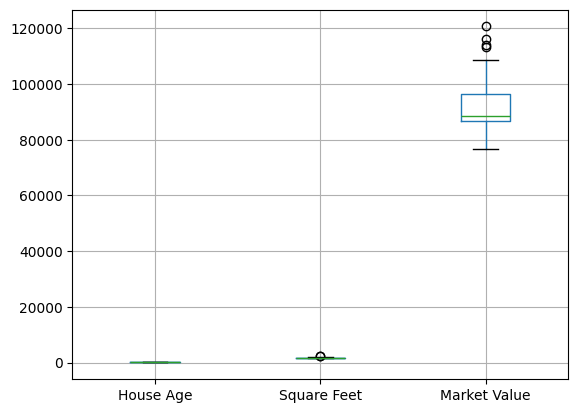

In [19]:
home_pp.boxplot()

The age, square feet, and market value are all of different orders of magnitude.  Scaling using minmax scalar.

In [20]:
scaler = MinMaxScaler()
home_ppS = pd.DataFrame(scaler.fit_transform(home_pp), columns=['House Age', 'Square Feet', 'Market Value'])
home_ppS.head()

,House Age,Square Feet,Market Value
0,1.000000,0.380531,0.303855
1,0.833333,0.493363,0.630385
2,0.833333,0.413717,0.378685
3,1.000000,0.380531,0.326531
4,0.833333,0.407080,0.573696


<Axes: >

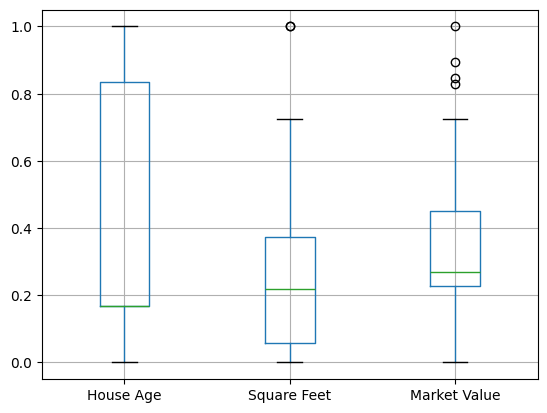

In [21]:
%matplotlib inline
home_ppS.boxplot()

Now that the data has been scaled and all data is within 0 and 1, we can easily see potential anomalys within Square feet and market value. Instead of utilizing Z-score to identify outliers, I will utilize anomaly detection below to identify and visualize the potential anomalys.  

### 2. Perform anomaly detection analysis using the approaches in Sections 9.1 and 9.2. (20 points)
For each approach, summarize your findings and provide visualization.

First, I want to see the probability distribution of the data


<Axes: ylabel='Density'>

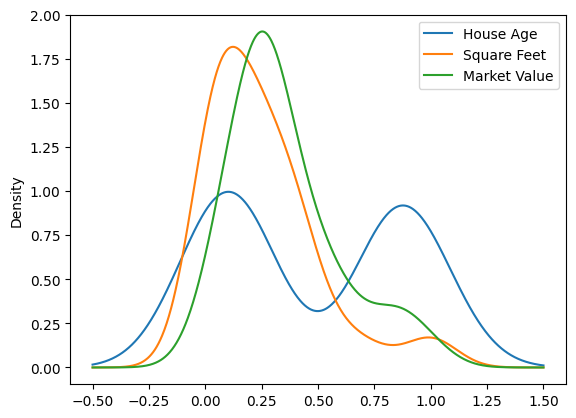

In [22]:
home_ppS.plot(kind='density')

The 'House Age' data is starkly not normal distribution.  The 'Square Feet' and 'Market Value' is not quite normal distribution either.  The 'House Age' data follows a bimodal distribution.  

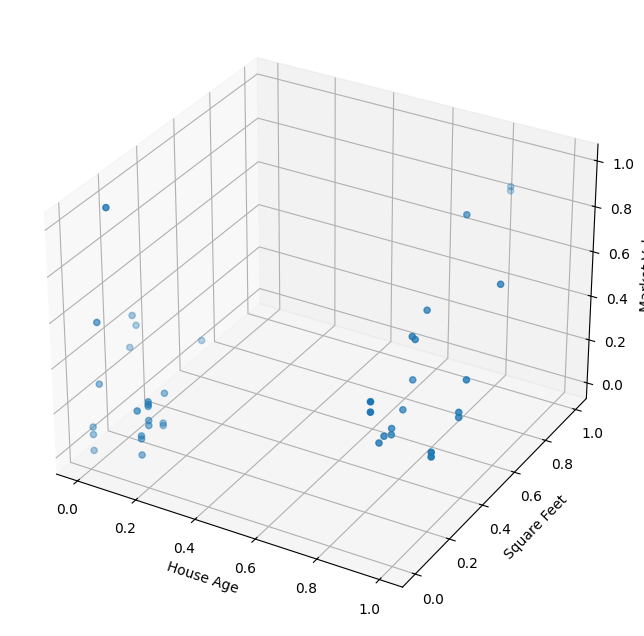

In [23]:
tdfig = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
tdfig.scatter(home_ppS['House Age'], home_ppS['Square Feet'], home_ppS['Market Value'])
tdfig.set_xlabel('House Age')
tdfig.set_ylabel('Square Feet')
tdfig.set_zlabel('Market Value')
plt.show()

There are two clearly visible clusters on the 'House Age' axis.  The data does not follow a multivariate normal distribution since the 'House Age' data is bimodal.  Scikit demonstrates the ability of some outlier detection algorithms work well with bimodal data as seen in [Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html). I will utilise the Mahalanobis distance to visualize and identify potential anomolies.

In [29]:
meanValue = home_ppS.mean()
covValue = home_ppS.cov()
print(meanValue, covValue)

House Age       2.907727e-17
Square Feet     3.700743e-17
Market Value    2.114711e-17
dtype: float64               House Age  Square Feet  Market Value
House Age      0.163844     0.063677      0.035008
Square Feet    0.063677     0.059364      0.042635
Market Value   0.035008     0.042635      0.057264


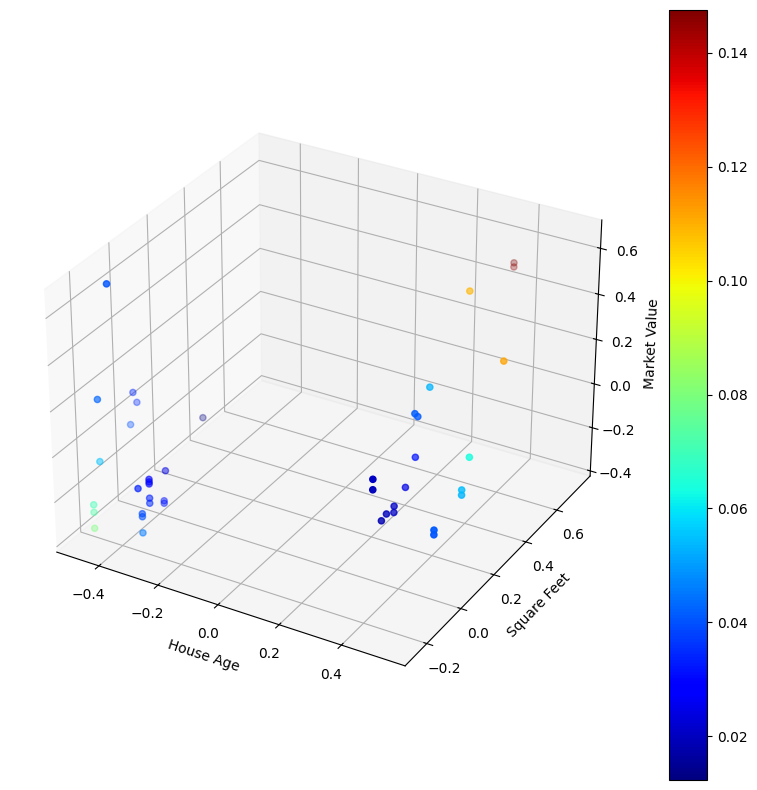

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

X = home_ppS.values
S = covValue.values
for i in range(3):
    X[:,i] = X[:,i] - meanValue[i]

def mahalanobis(row):
    return np.matmul(row,S).dot(row)

anomaly_score = np.apply_along_axis(mahalanobis, axis=1, arr=X)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(home_ppS['House Age'], home_ppS['Square Feet'], home_ppS['Market Value'],c=anomaly_score,cmap='jet')
ax.set_xlabel('House Age')
ax.set_ylabel('Square Feet')
ax.set_zlabel('Market Value')
fig.colorbar(p)
plt.show()

It was expected the distance measurement would be centered between the bimodal peaks of 'House Age'. There are outliers detected on the outer edges of the bimodal peaks.  This distance measurement is not suitable for bimodal distributions.  Next a distance based approach (KNN) will be utilized, I expect this to perform better at detecting anomolies compared to the mahalanobis method.  I selected K to be $\sqrt{42} = \sim6$

[0.17116472 0.26400136 0.17777663 0.17776146 0.26644899 0.34512707
 0.17751724 0.21428144 0.1462442  0.17192905 0.27155578 0.25437054
 0.16913006 0.64843795 0.64026649 0.17995137 0.45218722 0.22472045
 0.18322101 0.16691329 0.08668597 0.17835083 0.11771724 0.12034964
 0.11165175 0.13032121 0.08702491 0.24862227 0.11560158 0.12110834
 0.0892131  0.17182333 0.21514782 0.07256236 0.21053671 0.12062961
 0.30091522 0.17025571 0.33077248 0.0861678  0.25816212 0.72294419]


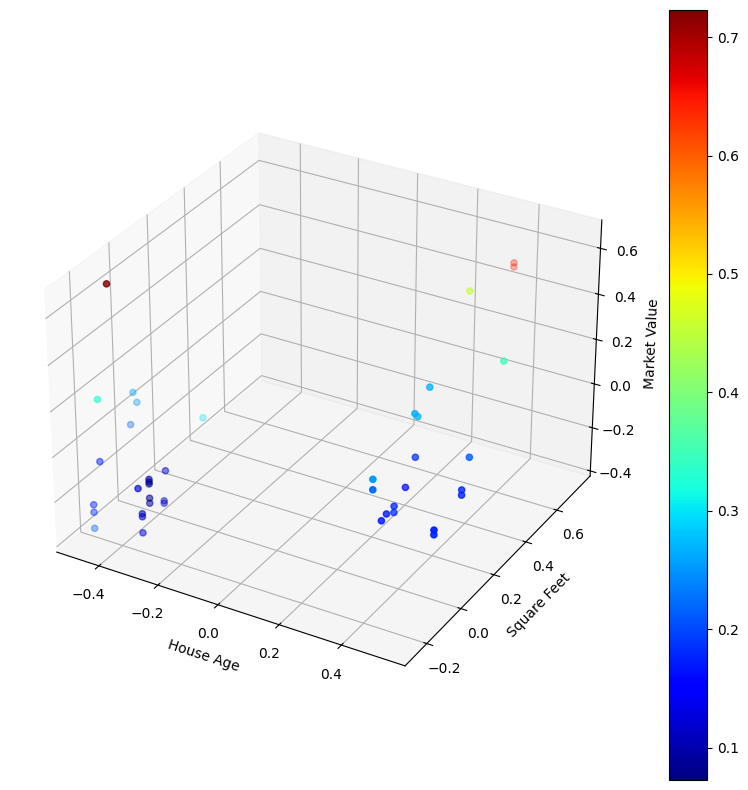

In [26]:
knn = 6
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(home_ppS.values)
distances, indices = nbrs.kneighbors(home_ppS.values)

anomaly_score = distances[:,knn-1]
print(anomaly_score)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(home_ppS['House Age'], home_ppS['Square Feet'], home_ppS['Market Value'],c=anomaly_score,cmap='jet')
ax.set_xlabel('House Age')
ax.set_ylabel('Square Feet')
ax.set_zlabel('Market Value')
fig.colorbar(p)
plt.show()

The KNN distance method with $k=6$, worked successfully detected anomolies in the bimodal distribution set.  The red and orange dots above are the deteted anomolies.

### 3. Perform at least two of the four approaches implemented in the sklearn package (robust covariance, random forest, one-class SVM, LOF) (20 points). ###

For each approach, summarize your findings and provide visualization. See this page for details and examples: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html

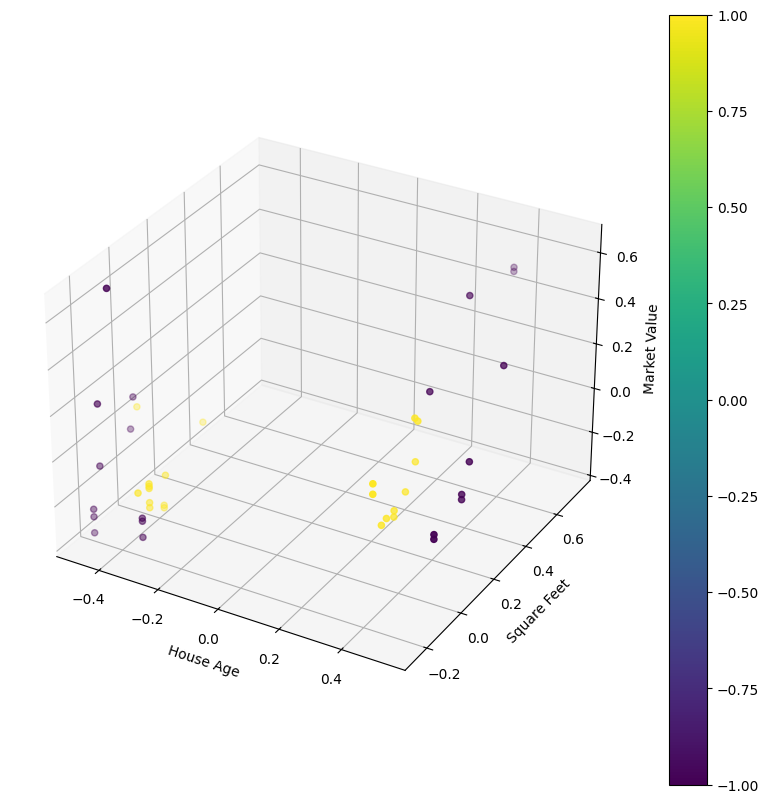

In [27]:
OCS_pred = OneClassSVM(gamma='auto').fit(home_ppS)
OCS_pred.predict(home_ppS)
OCS_pp = OCS_pred.score_samples(home_ppS)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(home_ppS['House Age'], home_ppS['Square Feet'], home_ppS['Market Value'],c=OCS_pred.fit(home_ppS).predict(home_ppS))
ax.set_xlabel('House Age')
ax.set_ylabel('Square Feet')
ax.set_zlabel('Market Value')
fig.colorbar(p)
plt.show()


The one class SVM identified multiple anomolies (in purple).  When performing this method, the gamma was altered, but each gamma (from 1 - 1000) identified anomolies in the center of the clusters.  It was determined that the 'auto' method for gamma was best.  Even with the gamme set to auto, there were 21 points determined to be anomolie (alomost half).  This is not a good anomoly detection method for this dataset. 

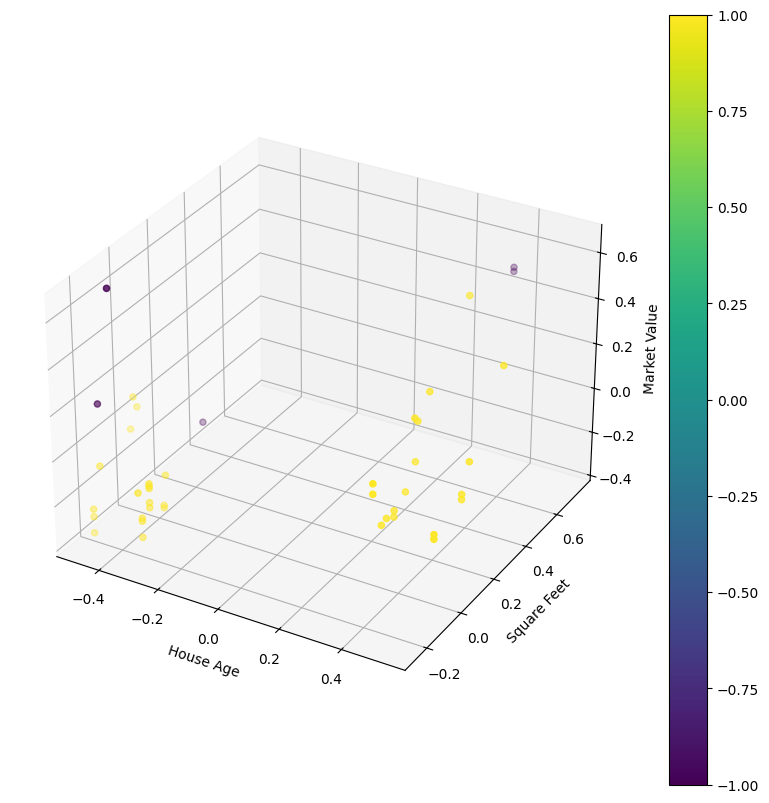

In [28]:
LOFclf = LocalOutlierFactor(n_neighbors=6)
LOFclf.fit_predict(home_ppS)

LOF_pp = OCS_pred.score_samples(home_ppS)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(home_ppS['House Age'], home_ppS['Square Feet'], home_ppS['Market Value'],c=LOFclf.fit_predict(home_ppS))
ax.set_xlabel('House Age')
ax.set_ylabel('Square Feet')
ax.set_zlabel('Market Value')
fig.colorbar(p)
plt.show()

The local outlier factor method performed better at segregating anomolies and valid points.  Only 5 points were determined to be anomolies.  This method performed much better compared to SVM.